In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load

In [4]:
def move_column_after(df, col, destination):
    cols = df.columns.tolist()
    cols.remove(col)
    cols.insert(cols.index(destination) + 1, col )
    return df[cols]

def override_columns(stats: pd.DataFrame):
    def column_div(lhs, rhs):
        return np.where(rhs != 0, lhs / rhs, 0)

    stats["referenced non-empty / referenced"] = column_div(stats["referenced non-empty"], stats["referenced"])
    stats["read non-empty / referenced"] = column_div(stats["read non-empty"], stats["referenced"])
    stats["used / referenced"] = column_div(stats["used"], stats["referenced"])

    stats["optimized away non-empty / unused non-empty"] = column_div(stats["optimized away non-empty"], stats["unused non-empty"])
    stats["dependent / unused non-empty"] = column_div(stats["dependent"], stats["unused non-empty"])
    stats["other unused non-empty / unused non-empty"] = column_div(stats["other reasons unused non-empty"], stats["unused non-empty"])

    stats["polluted / referenced non-empty"] = column_div(stats["polluted"], stats["referenced non-empty"])
    stats["used polluted / used"] = column_div(stats["used polluted"], stats["used"])
    stats["used polluted / polluted"] = column_div(stats["used polluted"], stats["polluted"])

    return stats

def load_stats(filename, totals = False):
    stats = pd.read_csv(filename)

    # Split to name and set
    stats[["set", "name"]] = stats["name"].str.split(":", expand=True)
    stats = move_column_after(stats, "set", "name")

    # Set index, sort
    stats.set_index("name", inplace=True)
    stats.sort_index(inplace=True)

    if totals:
        stats = override_columns(stats)

    return stats

def load_all_stats(filename, totals = False):
    stats = pd.read_csv(filename)

    # Set index, sort
    stats.index = stats["benchmark"].astype(str) + ":" + stats["closure"].astype(str)
    stats.sort_index(inplace=True)

    if totals:
        stats = override_columns(stats)

    return stats

# Plot

In [5]:
def plot(df: pd.DataFrame, index, columns,
         title = None,
         figsize=(15, 5), colors = None,
         labels = None, legend = None,
         xlabel = None, ylabel = None):
    df = df.copy()
    df.index = index

    ax = df[columns].plot(
        kind="bar",
        figsize=figsize,
        color=colors
    )

    if labels == "values":
        labels = [df[col].round(2) for col in columns]

    if labels is not None:
        for container, l in zip(ax.containers, labels):
            ax.bar_label(container, labels=l, label_type="edge", padding=2)

    plt.legend(legend, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=len(df.columns))

    if title is not None:
        plt.title(title)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)

    plt.show()

In [7]:
def plot_aggregate(df, total = False):
    index = df.index + "\n(" + df["referenced"].astype(str) + " referenced slots)"

    plot(
        df,
        index = index,
        columns = [
            "referenced non-empty / referenced",
            "read non-empty / referenced",
            "used / referenced"
        ],

        title= "Usage of slots across closure compilations",

        colors=["tab:blue", "orange", "tab:red"],

        labels = [
            df["referenced non-empty"],
            df["read non-empty"],
            df["used"]
        ] if total else "values",

        legend=[
            "% of non-empty slots (referenced non-empty / referenced)",
            "% of read non-empty slots (read non-empty / referenced)",
            "% of used non-empty slots (used non-empty / referenced)"
        ],

        ylabel="Percentage out of referenced"
    )

def plot_all(df, title):
    plot(
        df,
        index = df["referenced"],
        columns = [
            "referenced non-empty / referenced",
            "read non-empty / referenced",
            "used / referenced"
        ],

        title=title,

        figsize=(len(df) / 2, 5),
        colors=["tab:blue", "orange", "tab:red"],

        legend=[
            "% of non-empty slots (referenced non-empty / referenced)",
            "% of read non-empty slots (read non-empty / referenced)",
            "% of used non-empty slots (used non-empty / referenced)"
        ],

        xlabel="Referenced slots",
        ylabel="Percentage out of referenced"
    )

def plot_unused(df, totals = False):
    index = df.index + "\n(" + df["unused non-empty"].astype(str) + " unused non-empty slots)"

    plot(df,
        index = index,
        columns=["optimized away non-empty / unused non-empty", "dependent / unused non-empty"],

        title="Unused non-empty slots",

        colors=["tab:green", "tab:brown"],

        labels=[df["optimized away non-empty"], df["dependent"]]
            if totals else "values",
        legend=[
            "% of non-empty slots optimized away (optimized away non-empty / unused non-empty)",
            "% of redundant slots (redundant / unused non-empty)"
        ],

        ylabel="Percentage out of unused non-empty"
    )


In [8]:
stats = load_stats("results/stats.csv")
stats_totals = load_stats("results/stats.csv", True)

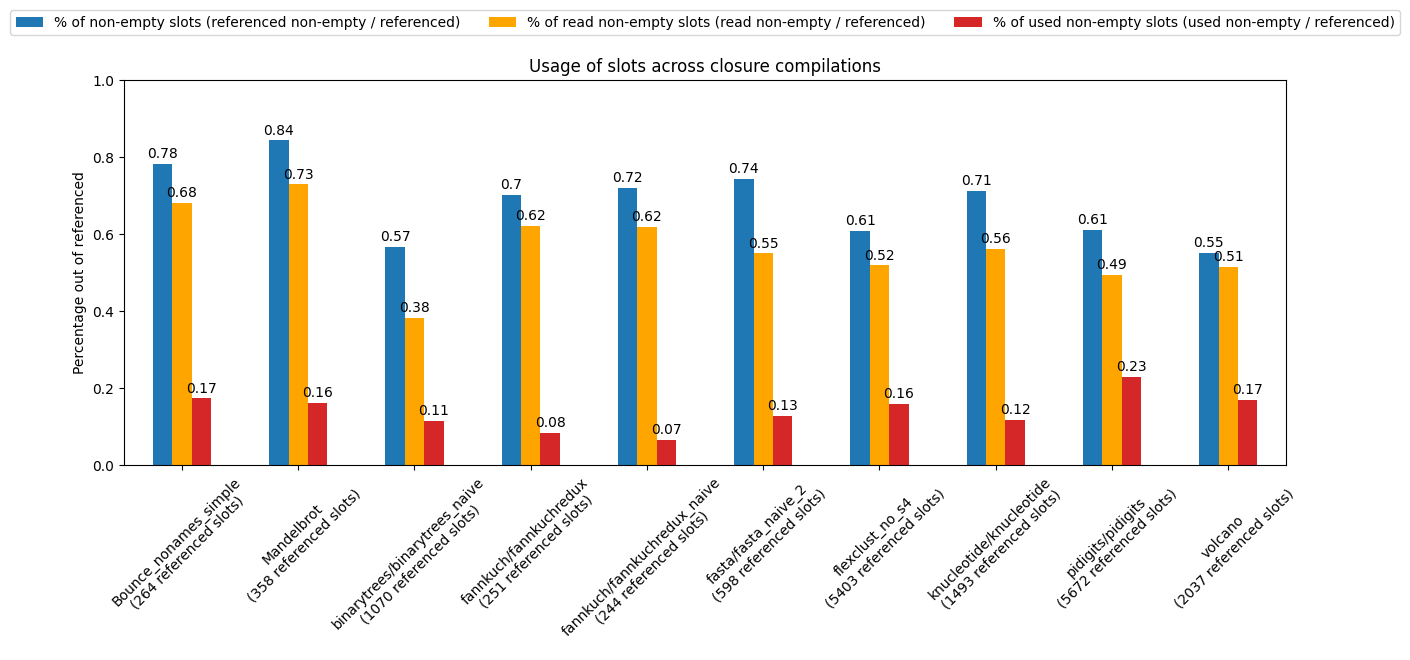

In [9]:
plot_aggregate(stats)
# plot_aggregate(stats_totals, True)

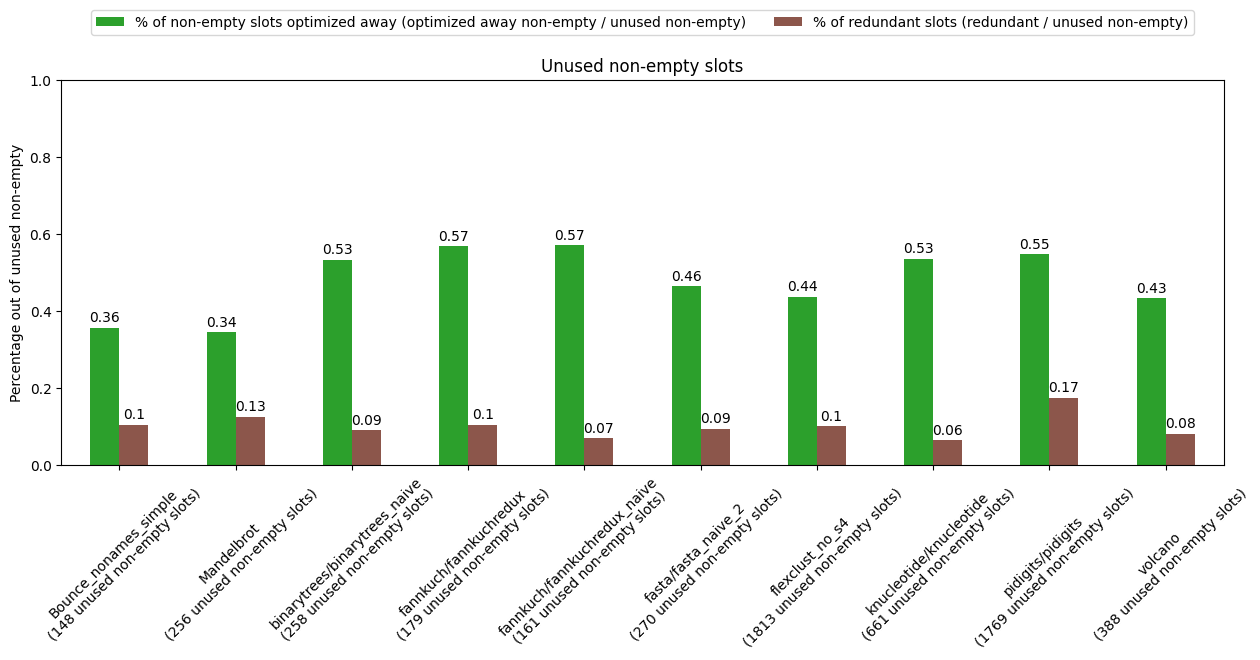

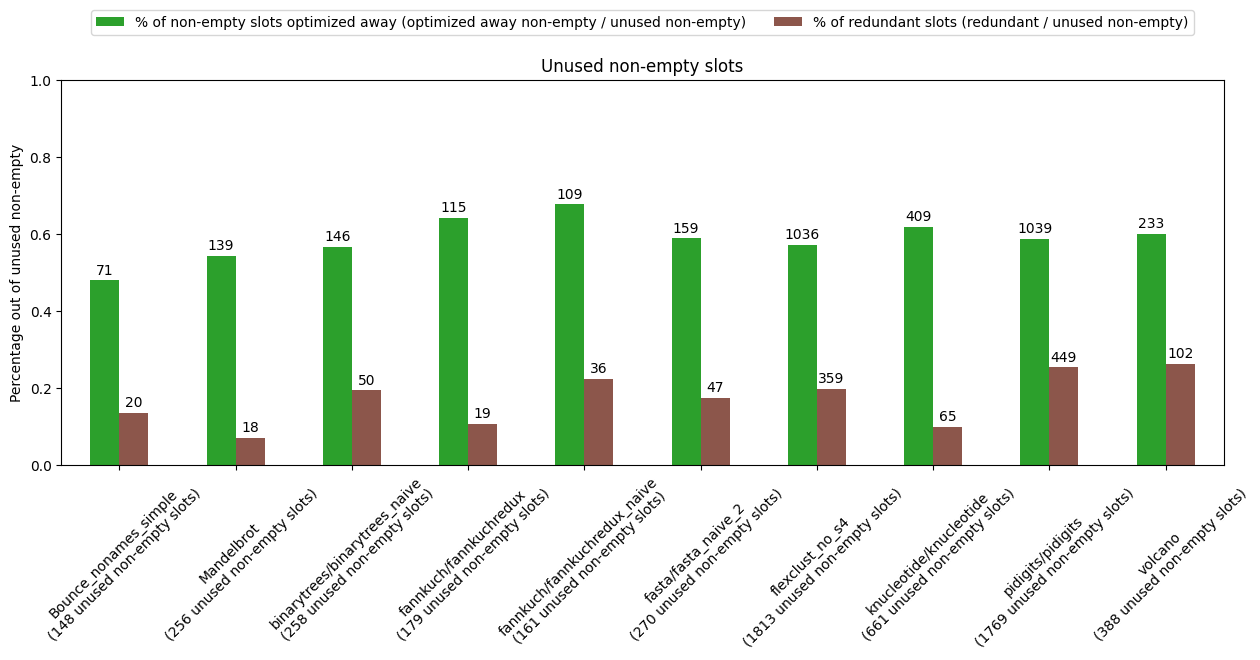

In [10]:
plot_unused(stats)
plot_unused(stats_totals, True)

In [124]:
poll = stats[["closure version compilations", "referenced", "referenced non-empty", "used"] + [ col for col in stats.columns if "polluted" in col ]].copy()
poll.loc["[means]"] = poll.mean()

int_cols = ["closure version compilations", "referenced", "referenced non-empty", "used", "polluted", "used polluted"]
poll[int_cols] = poll[int_cols].astype(int)

display(poll.round(2))

,closure version compilations,referenced,referenced non-empty,used,polluted,used polluted,polluted / referenced non-empty,used polluted / used,used polluted / polluted
name,,,,,,,,,
Bounce_nonames_simple,11,264,160,12,16,3,0.22,0.33,0.33
Mandelbrot,14,358,280,24,19,4,0.21,0.19,0.22
binarytrees/binarytrees_naive,22,1070,341,83,72,21,0.21,0.34,0.32
fannkuch/fannkuchredux,6,251,184,5,6,1,0.12,0.33,0.17
fannkuch/fannkuchredux_naive,5,244,164,3,6,1,0.15,0.50,0.17
fasta/fasta_naive_2,17,598,343,73,23,5,0.09,0.16,0.24
flexclust_no_s4,145,5334,2492,701,245,58,0.17,0.21,0.25
knucleotide/knucleotide,62,1511,827,151,71,12,0.10,0.16,0.22
pidigits/pidigits,92,5672,2766,997,674,319,0.29,0.31,0.47


## Stats all

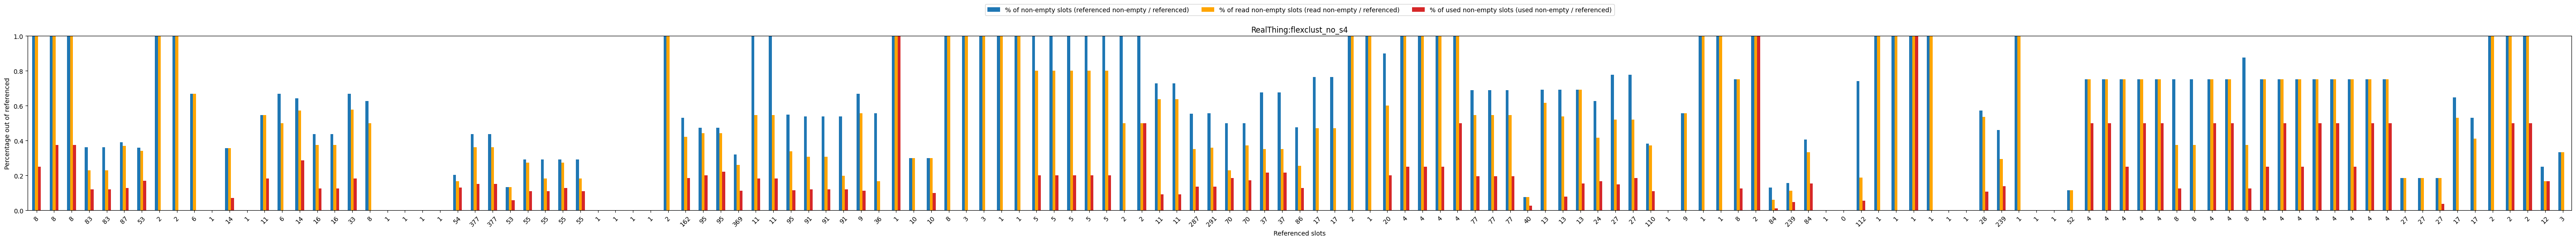

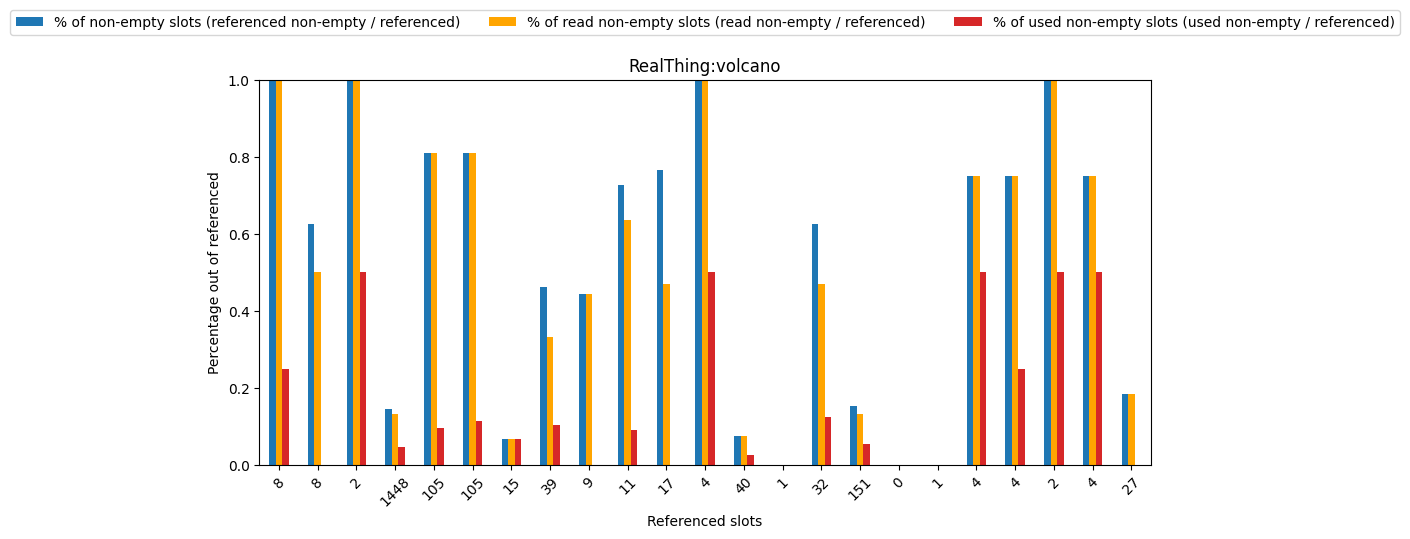

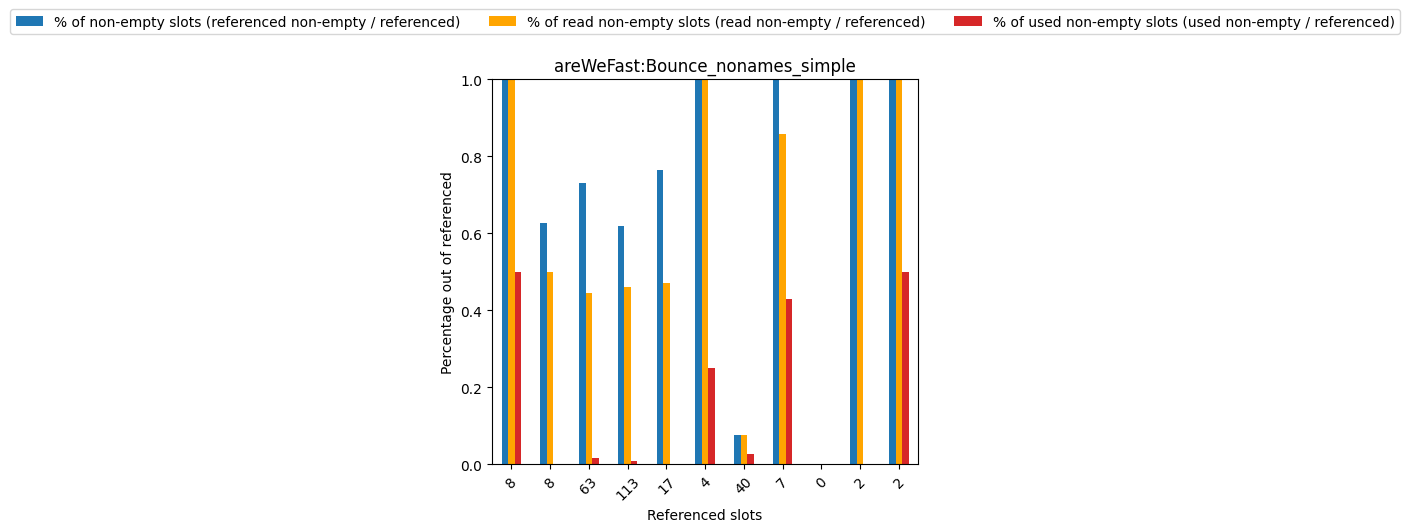

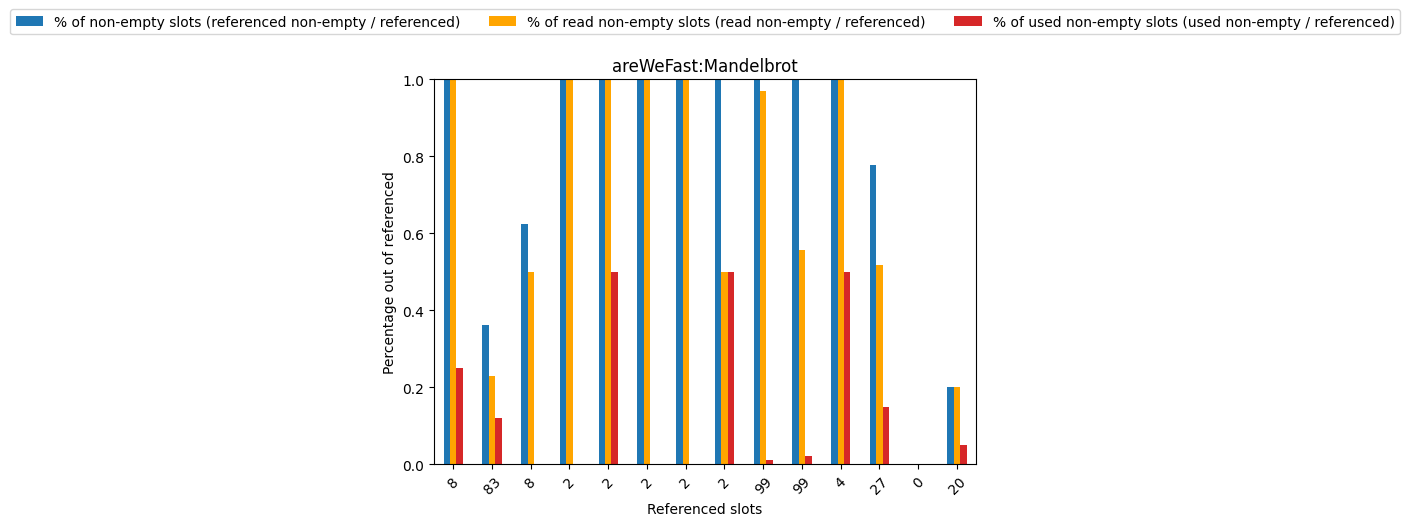

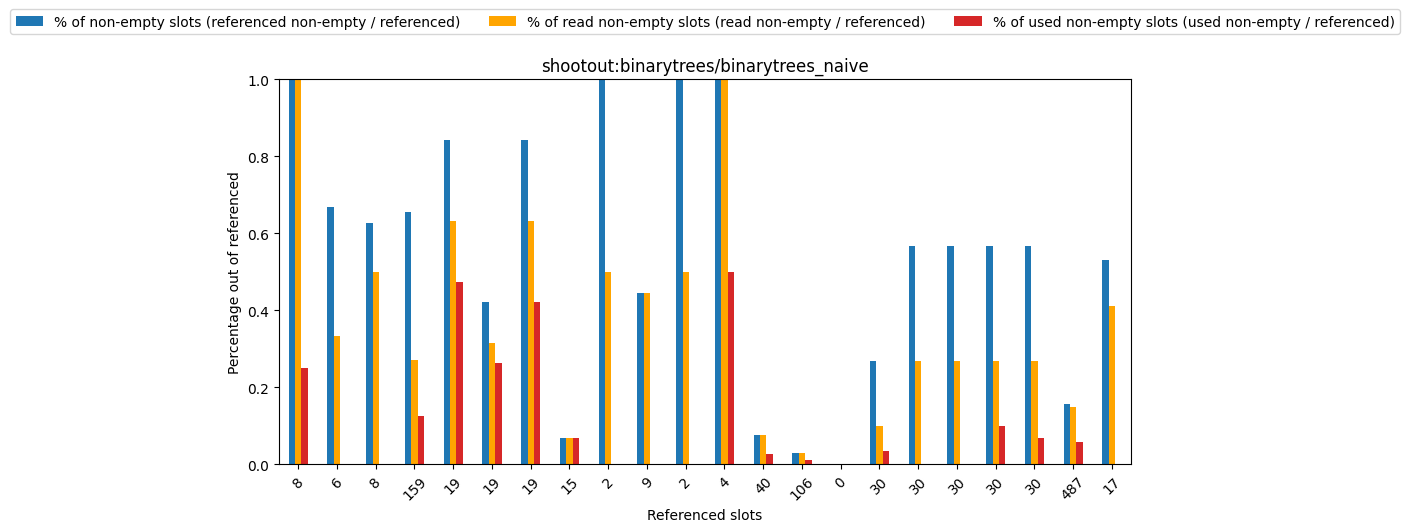

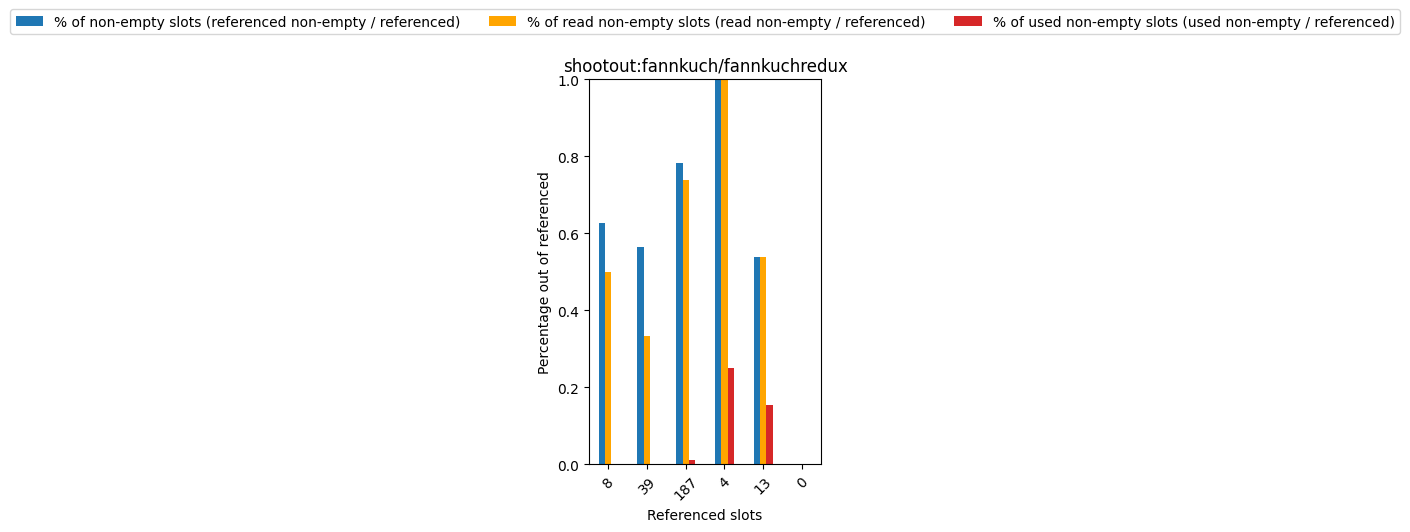

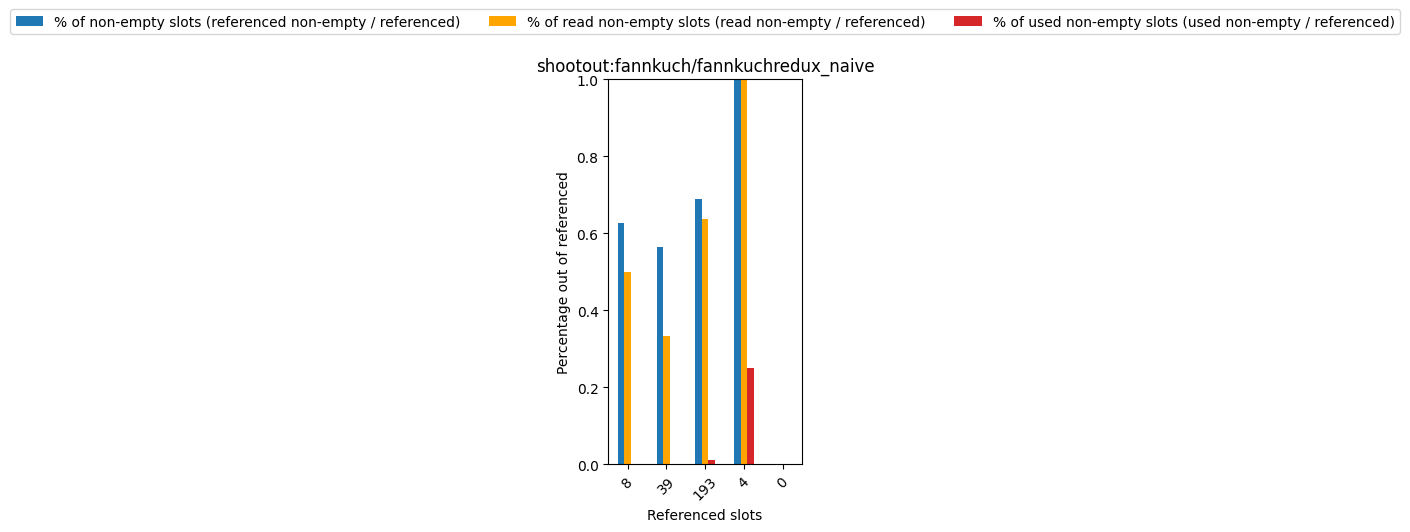

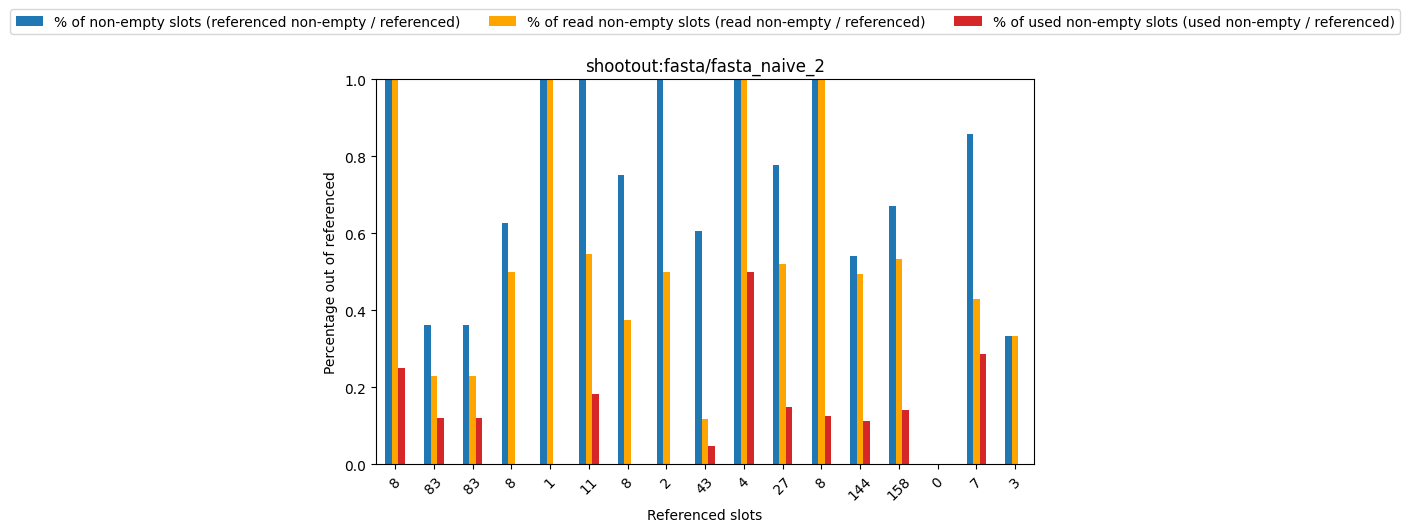

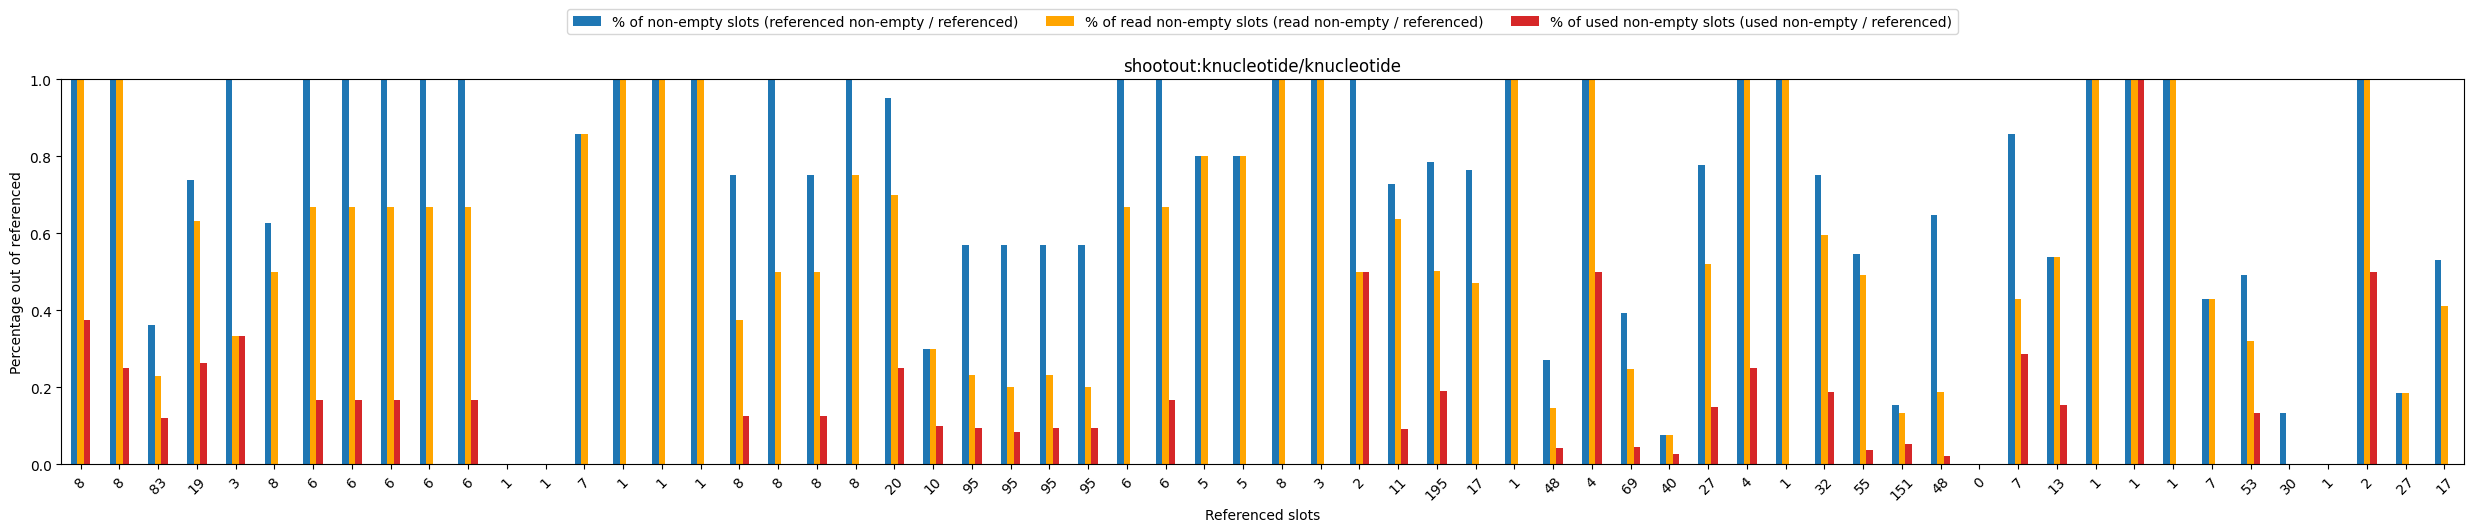

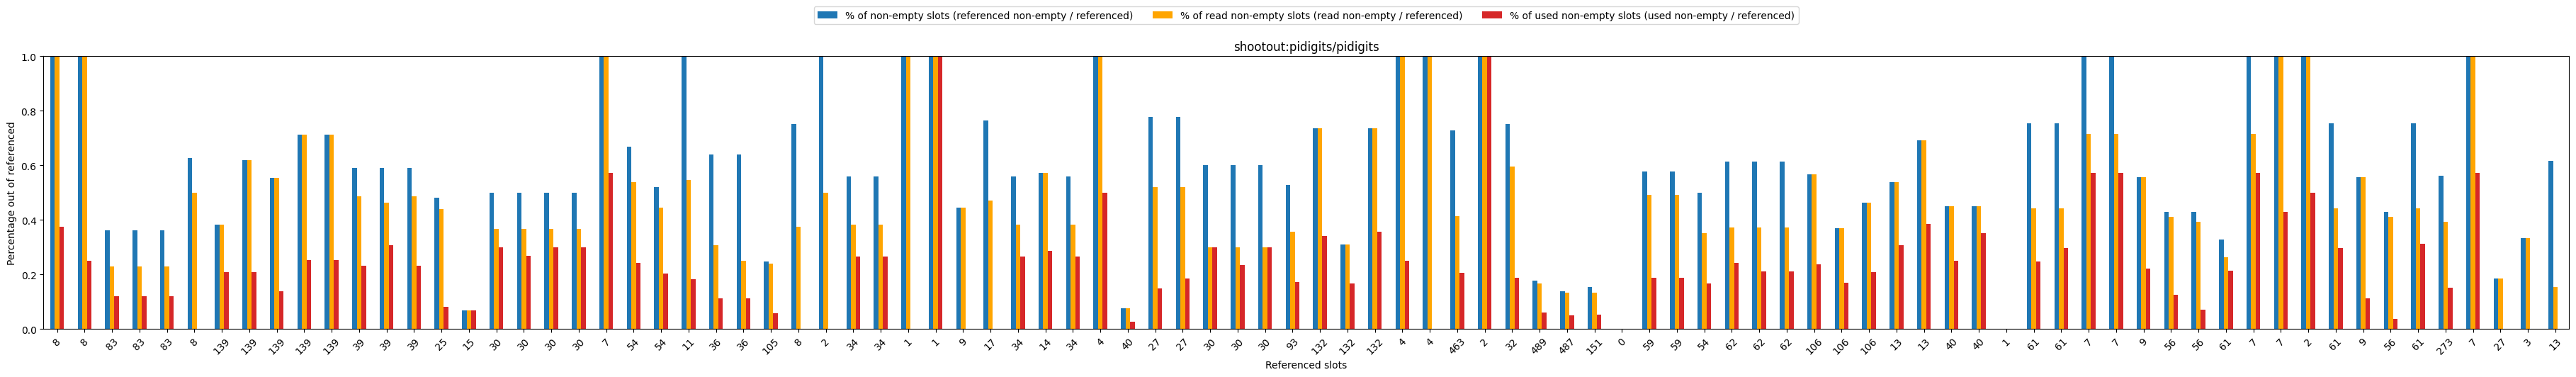

In [73]:
stats_all = load_all_stats("results/stats_all.csv")
for benchmark, df in stats_all.groupby("benchmark"):
    plot_all(df, benchmark)

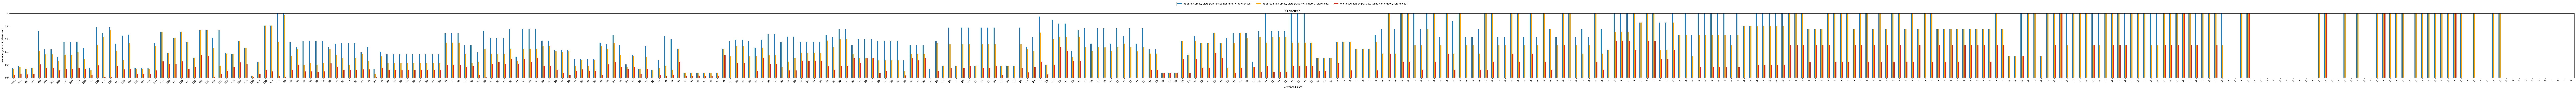

In [72]:
stats_all_sorted = stats_all.sort_values(by="referenced", ascending=False)
plot_all(stats_all_sorted, "All closures")